<a href="https://colab.research.google.com/github/bosecodes/DL-with-Python/blob/master/GAN_MNISTic_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Loading the MNIST dataset
from keras.datasets.mnist import load_data

(x_train, y_train), (x_test, y_test) = load_data()

# Summarise the shape of the dataset
print('Train : ', x_train.shape, y_train.shape)
print('Test : ', x_test.shape, y_test.shape)

Train :  (60000, 28, 28) (60000,)
Test :  (10000, 28, 28) (10000,)


# **Defining and Training the Discriminator model**



The first step is to define the Discriminator Model.
The model must take a sample image from our dataset as input and output a classification prediction as to whether the sample is real or fake.

This is a binary classification problem:

- Inputs: Image with one channel and 28x28 in size
- Output: Binary classification, 1 or 0, likelihood of the sample to be real or fake

This Discriminator model has **2 convolutional layers with 64 filters each, a 3x3 kernel and a larger than normal stride of 2.** There are no Pooling layers and a single node output layer with the sigmoid activation function to predict whether the input sample is real or fake. The model is trained to minimize **binary cross entropy loss function**, which is appropriate for binary classification.

We will use LeakyRELU (instead of RELU), Dropout, and Adam optimizer, with learning rate 0.0002 and momentum 0.5. This all is done as best practice.


In [0]:
# Importing essential libraries

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, LeakyReLU
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model

#defining the standalone Discriminator model

def define_discriminator(in_shape= (28,28,1)):
  model = Sequential()
  model.add(Conv2D(64, (3,3), strides = (2,2), padding = 'same', input_shape = in_shape))
  model.add(LeakyRELU(alpha = 0.2))
  model.add(Dropout(0.4))
  model.add(Conv2D(64, (3,3), strides = (2,2), padding = 'same'))
  model.add(LeakyRELU(alpha = 0.2))
  model.add(Dropout(0.4))
  model.add(Flatten())
  model.add(Dense(1, activation = 'sigmoid'))

  # compile the model
  opt = Adam(lr = 0.0002, beta_1 = 0.5)
  model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])
  return model

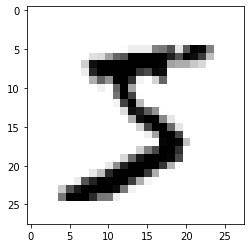

In [4]:
import matplotlib.pyplot as plt
plt.imshow(x_train[0], cmap = 'gray_r')

In [5]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 36864)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                368650    
Total params: 406,218
Trainable params: 406,218
Non-trainable params: 0
_________________________________________________________________


In [0]:
# The images are 2d arrays of pixels and CNNs expect 3d arrays of images as input
# X = expand_dims(x_train, axis = -1)

# X = X.astype('float32')
# X /= 255

# The below function does exactly that

In [0]:
def load_real_samples():
  # load mnist dataset
  (x_train, _), (_, _) = load_data()
  # Expand to 3d, add channel dimensions
  X = expand_dims(x_train, axis = -1)
  X = X.astype('float32')
  X /= 255
  return X

The model will be updated in batches, specifically with a collection of generated samples.

Good training through a definite epoch is possible via Stochastic Gradient Descent, and that requires the training dataset to be shuffled prior to each epoch. A simpler approach would be to select random samples of images from the training dataset.

The following function will take the training dataset as the argument and will select a random subsample of images, it will also return class labels for the sample, specifically a class label of 1, to indicate real images.


In [0]:
import random

# select real samples

def generate_real_samples(dataset, n_samples):
  # choose random instances
  ix = random.randint(0, dataset.shape[0], n_samples)
  # retrieve the selected images
  X = dataset[ix]
  # generate the 'real' class labels(1)
  y = ones((n_samples, 1))
  return X,y

Now, we need a source of fake images. 
Since we don't have a generator model yet, we can generate images comprised of random ixel values and their associated class label would be 0, for fake.


In [0]:
import random

# generate n fake samples with class labels
def generate_fake_samples(n_samples):
  X = random.rand(28*28*n_samples)
  # reshape into a batch of grayscale images
  X = X.reshape((n_samples, 28, 28, 1))
  # generate 'fake' class labels (0)
  y = zeros((n_samples, 1))
  return X,y

# Finally we train the discriminator model

This involves repeatedly retrieving samples of real images and samples of fake images and updating the model for a fixed number of iterations.

We will skip the idea of epochs now (eg, complete passes through the training dataset), and fit the discriminator model for a fixed number of batches. The model will learn to discriminate between real and fake images(randomly generated) rapidly, and therefore not many batches will be required before it discriminates perfectly.

The following function does exactly this, we are using a batch size of 256 images where 128 are real, 128 are fake for each iteration.

We update the discriminator model seperately for real and fake examples so that we can calculate the accuracy of the model on each sample prior to the update. This gives insight into how the discriminator model is performing over time.


In [0]:
# train the discriminator model
def train_discriminator(model, dataset, n_iter = 100, n_batch = 256):
  half_batch = int(n_batch/2)
  # manually enumerate epochs
  for i in range(n_iter):
    # get randomly selected 'real' samples
    X_real, y_real = generate_real_samples(dataset, half_batch)
    #f update discriminator on real samples
    _, real_acc = model.train_on_batch(X_real, y_real)
    # get randomly selected 'fake' samples
    X_fake, y_fake = generate_fake_samples(half_batch)
    # update discriminator on fake samples
    _, fake_acc = model.train_on_batch(X_fake, y_fake)
    # summarize performance
    print('>%d real= %.0f%% fake=%.0f%%' %(i+1, real_acc*100, fake_acc*100))

Tying all of this together, the complete example of training an instance of the discriminator model on real and randomly generated (fake) images is listed below.


In [13]:
# example of training the discriminator model on real and random mnist images

#import the necessary packages
from numpy import expand_dims
from numpy import ones
from numpy import zeros
from numpy.random import rand
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
 
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model
 
# load and prepare mnist training images
def load_real_samples():
	# load mnist dataset
	(trainX, _), (_, _) = load_data()
	# expand to 3d, e.g. add channels dimension
	X = expand_dims(trainX, axis=-1)
	# convert from unsigned ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [0,1]
	X = X / 255.0
	return X
 
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y
 
# generate n fake samples with class labels
def generate_fake_samples(n_samples):
	# generate uniform random numbers in [0,1]
	X = rand(28 * 28 * n_samples)
	# reshape into a batch of grayscale images
	X = X.reshape((n_samples, 28, 28, 1))
	# generate 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y
 
# train the discriminator model
def train_discriminator(model, dataset, n_iter=100, n_batch=256):
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_iter):
		# get randomly selected 'real' samples
		X_real, y_real = generate_real_samples(dataset, half_batch)
		# update discriminator on real samples
		_, real_acc = model.train_on_batch(X_real, y_real)
		# generate 'fake' examples
		X_fake, y_fake = generate_fake_samples(half_batch)
		# update discriminator on fake samples
		_, fake_acc = model.train_on_batch(X_fake, y_fake)
		# summarize performance
		print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))
 
# define the discriminator model
model = define_discriminator()
# load image data
dataset = load_real_samples()
# fit the model
train_discriminator(model, dataset)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
>1 real=45% fake=17%
>2 real=70% fake=23%
>3 real=64% fake=47%
>4 real=56% fake=60%
>5 real=50% fake=80%
>6 real=61% fake=91%
>7 real=56% fake=97%
>8 real=66% fake=100%
>9 real=52% fake=100%
>10 real=60% fake=100%
>11 real=58% fake=100%
>12 real=61% fake=100%
>13 real=59% fake=100%
>14 real=59% fake=100%
>15 real=64% fake=100%
>16 real=62% fake=100%
>17 real=65% fake=100%
>18 real=65% fake=100%
>19 real=63% fake=100%
>20 real=70% fake=100%
>21 real=76% fake=100%
>22 real=81% fake=100%
>23 real=80% fake=100%
>24 real=82% fake=100%
>25 real=89% fake=100%
>26 real=94% fake=100%
>27 real=93% fake=100%
>28 real=90% fake=100%
>29 real=95% fake=100%
>30 real=97% fake=100%
>31 real=98% fake=100%
>32 real=99% fake=100%
>33 real=99% fake=100%
>34 real=99% fake=100%
>35 real=99% fake=100%
>36 real=99% fake=100%
>37 real=98% fake=100%
>38 real=100% fake=100%
>39 real=100% fake=100%
>

Running the above snippet 
- Step 1: Defines the model
- Step 2: Loads the MNIST Dataset
- Step 3: Trains the discriminator model

In our case the discriminator model learns to tell the difference between real and fake(random pixel generated) MNIST images very quickly, in about 38 batches.
